<h1> <center>Tilt Correction in Text Images </center></h1>
<h2> Course Project : Image Processing EE 610 </h2>
<p> Submitted By:- <ul> <li> Pankaj Singh (183079036)</li>
    <li> Amit Lohan (183079033) </li>
    <li> Devanshu Singh Gaharwar (16D070042)</li>
    </ul>
 </p>

In [1]:
# importing some necessary libraries
import cv2
import numpy as np
import skimage
import matplotlib.pyplot as plt
from PIL import Image

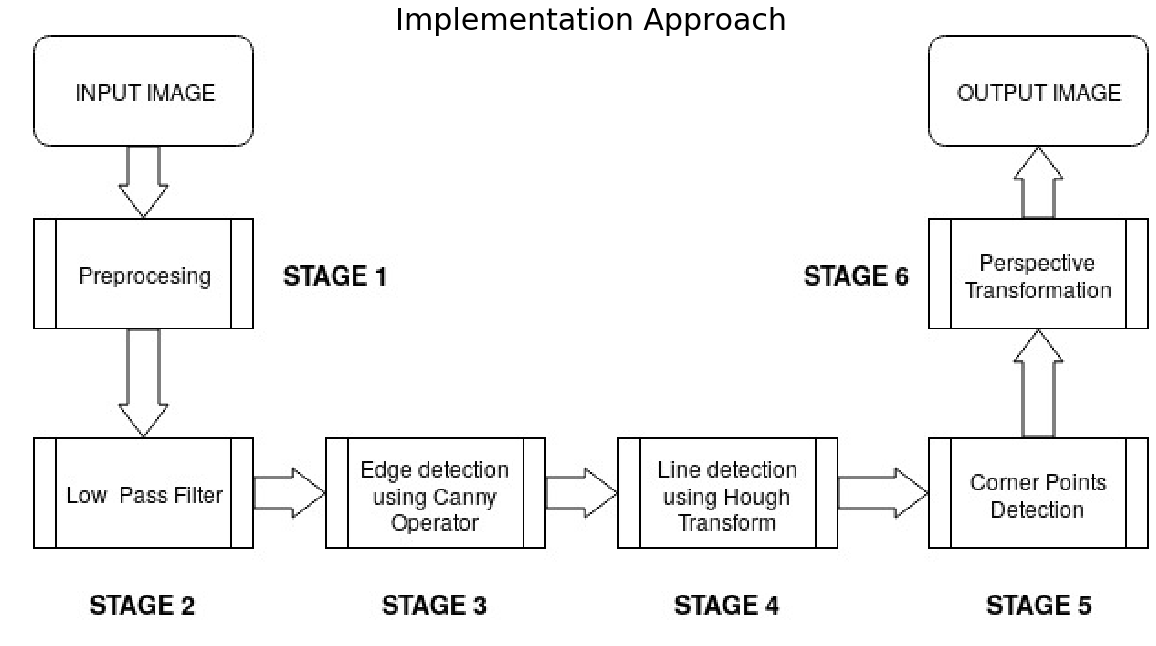

In [42]:
plt.figure(figsize = (20,12))
plt.imshow(Image.open('./data/extra/image_processing.jpg'))
plt.title('Implementation Approach', fontsize = 30)
plt.axis('Off')
plt.show()

<h1> STAGE 1 : Preprocessing </h1>

In [2]:
input_image = np.array(Image.open('./data/final.jpeg')) # reading the input image

<h3> RGB to Gray scale conversion </h3>

In [3]:
image = input_image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # getting gray scale from RGB image

In [4]:
gray.shape

(1280, 960)

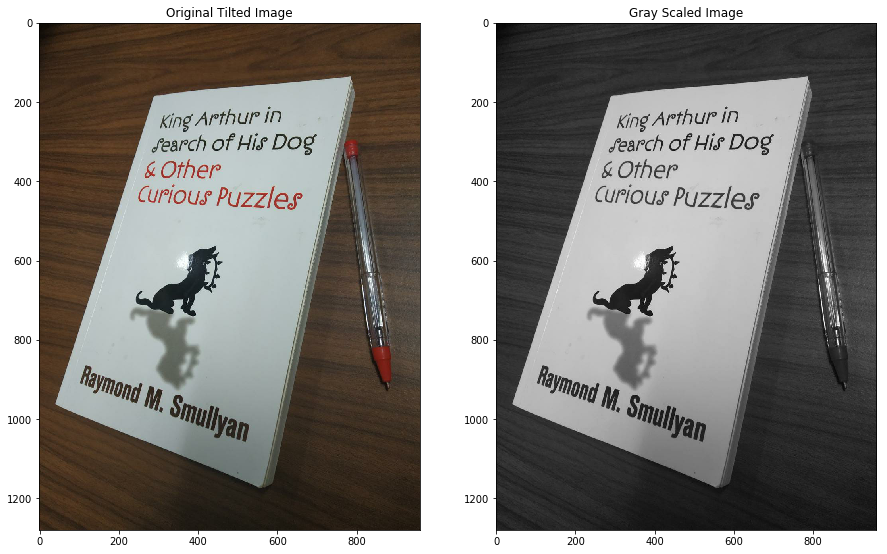

In [5]:
# Visualization
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Original Tilted Image")

ax = fig.add_subplot(1, 2,2)
plt.imshow(gray, cmap = 'gray')
plt.title("Gray Scaled Image")
plt.show()

<h1> STAGE 2 : Low Pass filtering </h1>
<p> We will use frequency domain Gaussian Blurring to suppress the high frequency content and smoothen out the image a bit to avoid unecessary edge detection. <p>

In [6]:
# fucntion to help with obtaining magnitude spectrum of fft and rescale the image for 
# display purposes.
def rescale(x):
    x = np.abs(x)
    x = x - np.min(x)
    x = (x * 255) / np.max(x)
    return x

In [7]:
#making a Gaussian low pass filter mask
gaussian_LP_filter_mask = np.zeros((2700, 2700))
D0 = 270
m = gaussian_LP_filter_mask.shape[0]
n = gaussian_LP_filter_mask.shape[1]
for i in range(m):
    for j in range(n):
        power = ((i -(m/2))**2 + (j -(n/2))**2) / (2 * D0**2)
        gaussian_LP_filter_mask[i, j] = np.exp(-power)

        
gaussian_LP_filter_mask = gaussian_LP_filter_mask.astype(float)

<p> We obatained 2700 point FFT  to avoid wrap around errors as the orginal image size is
(1280, 960) and did point wise multiplication of the obtained FFT with Gaussian filter mask
created above. Then we took it's inverse FFT to get low pass Gaussian fitered image. </p>

In [8]:
# getting image fft
gray_image_fft = np.fft.fft2(gray, s=(2700, 2700), axes=(-2, -1), norm=None) 

# doing low pass filterin in frequency domain using Gaussian filter.
filtered_image_fft = np.fft.fftshift(gray_image_fft) * gaussian_LP_filter_mask

# Taking IFFT and obtaining low pass filtered Image.
filtered_image = np.fft.ifft2(filtered_image_fft, s=None, axes=(-2, -1), norm=None)
filtered_image = rescale(filtered_image)[:image.shape[0], :image.shape[1]].astype(np.uint8)

<h3> Visualizations </h3>

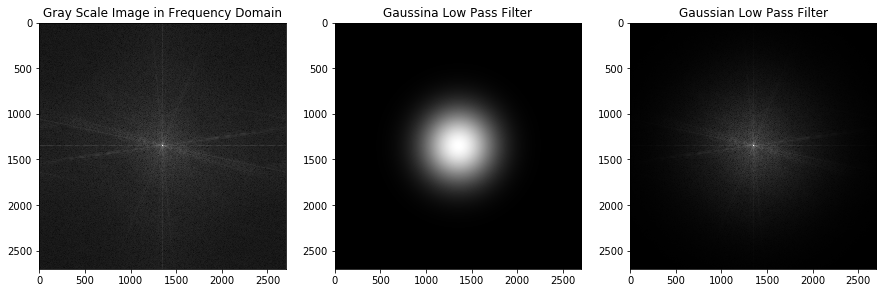

In [9]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(skimage.exposure.adjust_gamma(rescale(np.fft.fftshift(gray_image_fft)), 0.20), cmap = 'gray')
plt.title("Gray Scale Image in Frequency Domain")

ax = fig.add_subplot(1, 3,2)
plt.imshow(gaussian_LP_filter_mask, cmap = 'gray')
plt.title("Gaussina Low Pass Filter")

ax = fig.add_subplot(1, 3,3)
plt.imshow(skimage.exposure.adjust_gamma(rescale(filtered_image_fft), 0.20), cmap = 'gray')
plt.title("Gaussian Low Pass Filter")
plt.show()

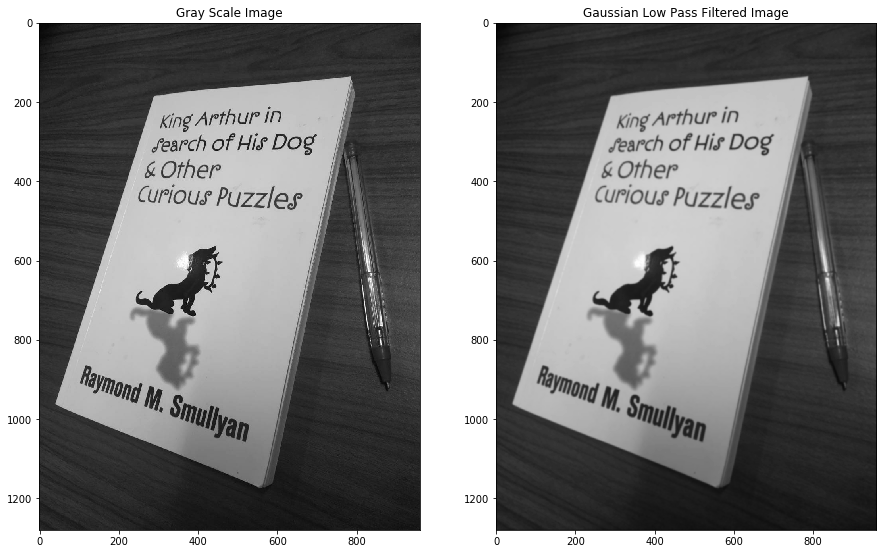

In [10]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(gray, cmap = 'gray')
plt.title("Gray Scale Image")

ax = fig.add_subplot(1, 2,2)
plt.imshow(filtered_image, cmap = 'gray')
plt.title("Gaussian Low Pass Filtered Image")
plt.show()

<h1> STAGE 3 : Edge detection using Canny Operator </h1>

In [11]:
edges = cv2.Canny(filtered_image, 100, 250)

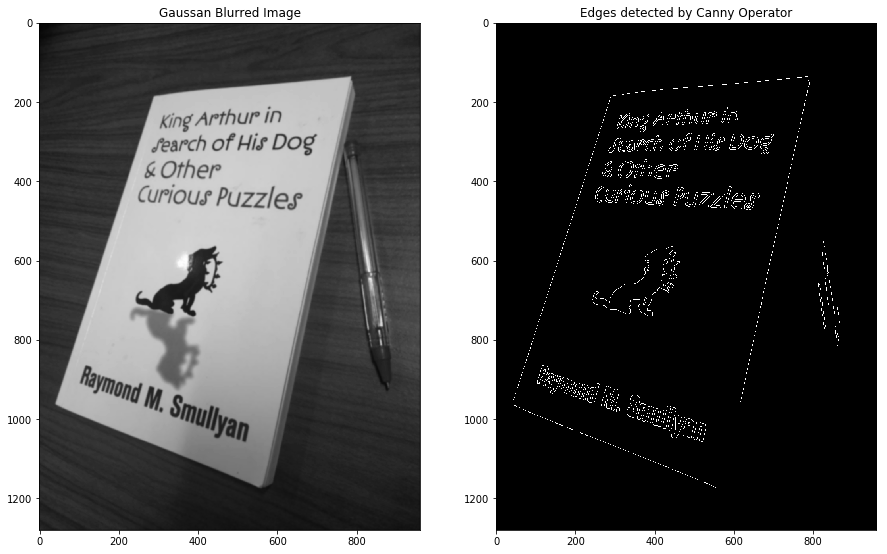

In [12]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(filtered_image, cmap = 'gray')
plt.title("Gaussan Blurred Image")

ax = fig.add_subplot(1, 2,2)
plt.imshow(edges, cmap = 'gray')
plt.title("Edges detected by Canny Operator")
plt.show()

<h1> STAGE 4 : Line Detection Using Hough Transform </h1>

In [13]:
class Line_Detection:
    
    def __init__(self, edges):
        self.edges = edges
        
    
    def get_hough_lines(self, min_line_len, max_line_len):
        lines = cv2.HoughLinesP(self.edges, 1, np.pi/180, 100,
                                minLineLength=min_line_len, maxLineGap=max_line_len)
        return lines
    
    
    def draw_hough_lines(self, lines):
        drawing = np.zeros(image.shape, np.uint8)
        for line in lines: 
            a, b, a1, b1 = line[0]
            cv2.line(drawing, (a,b), (a1, b1), (255, 255,255), 2)

        return drawing

In [14]:
line_detector = Line_Detection(edges)
lines = line_detector.get_hough_lines(min_line_len=300, max_line_len=366)
hough_lines = line_detector.draw_hough_lines(lines)

<h3> Visualization </h3>

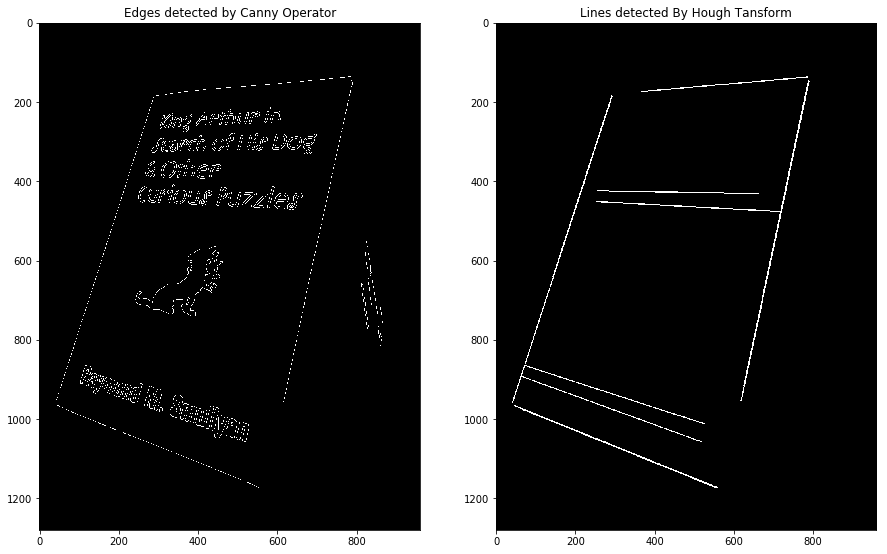

In [15]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 2, 2)
plt.imshow(hough_lines)
plt.title("Lines detected By Hough Tansform")

ax = fig.add_subplot(1, 2,1)
plt.imshow(edges, cmap = 'gray')
plt.title("Edges detected by Canny Operator")
plt.show()

<h1> STAGE 5 : Four Corner Points Detection</h1>

In [16]:
class Corner_Detection:
    
    def __init__(self, lines):
        self.lines = lines
           
    def get_corner_points(self):
        
        toplx, toply = 10000, 10000
        toprx, topry = -10000, 10000
        botlx, botly = 10000, -10000
        botrx, botry = -10000, -10000

        for line in self.lines:              # First Point
            arr = np.array(line).squeeze()
            
            x1, y1, x2, y2 = arr
            
            if -x1-y1>-toplx-toply:   ###  checking for min values of (x+y)
                toplx, toply = x1, y1
                
            if -x2-y2>-toplx-toply:
                toplx, toply = x2, y2
                
        for line in self.lines:                         # Second Point
            arr = np.array(line).squeeze()
            
            x1, y1, x2, y2 = arr

            if -y1+x1>toprx-topry:
                toprx, topry= x1, y1

            if -y2+x2>toprx-topry:
                toprx, topry = x2, y2

        for line in self.lines:                      # Third Point
            arr = np.array(line).squeeze()
            
            x1, y1, x2, y2 = arr

            if y1-x1>-botlx+botly:
                botlx, botly = x1, y1

            if y2-x2>-botlx+botly:
                botlx, botly = x2, y2

        for line in self.lines:                       # Fourth Point
            arr = np.array(line).squeeze()
            
            x1, y1, x2, y2 = arr

            if y1+x1>botrx+botry:
                botrx, botry = x1, y1

            if y2+x2>botrx+botry:
                botrx, botry = x2, y2
         
        # return all points in a tuple
        return (toplx, toply, toprx, topry, botlx, botly, botrx, botry)
    
    
    def visualize_corner_points(self, img, detected_points, point_size):
        toplx, toply, toprx, topry, botlx, botly, botrx, botry = detected_points
        
        cv2.circle(img,(toplx,toply), point_size, (0, 0, 255), -1)
        cv2.circle(img,(toprx,topry), point_size, (255, 255, 255), -1)

        cv2.circle(img,(botlx,botly), point_size, (0, 255, 0), -1)
        cv2.circle(img,(botrx,botry), point_size, (255, 0, 255), -1)
        
        return img

In [17]:
corner_detector = Corner_Detection(lines)        #instantiating the Corner detection
points = corner_detector.get_corner_points()     # getting the four detected corner points
img = input_image.copy()
plot_corner_points = corner_detector.visualize_corner_points(img, points, 26)

<h3> Visualization </h3>

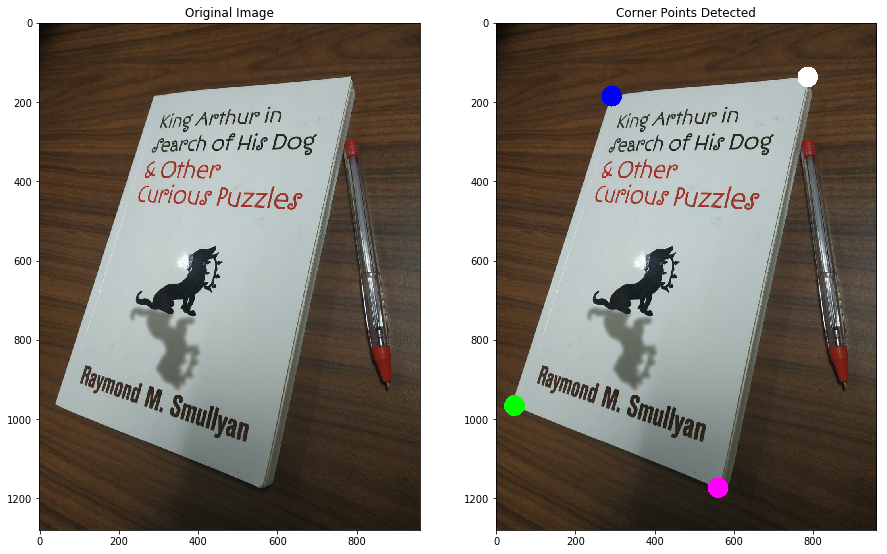

In [18]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 2, 2)
plt.imshow(plot_corner_points)
plt.title("Corner Points Detected")

ax = fig.add_subplot(1, 2,1)
plt.imshow(input_image)
plt.title("Original Image")
plt.show()

<h1> STAGE 6 : Perspective Transformation</h1>

In [19]:
class PerspectiveTransform:
    def __init__(self, detected_points):
        
        self.detected_points = detected_points
        
    def get_rectangle(self):
        toplx, toply, toprx, topry, botlx, botly, botrx, botry = self.detected_points
        pts = np.array([(toplx,toply),(toprx,topry),(botlx,botly),(botrx,botry)])
        
        rectangle = np.zeros((4, 2), dtype = "float32")
        
        sum_row = pts.sum(axis = 1)
        rectangle[0] = pts[np.argmin(sum_row)]
        rectangle[2] = pts[np.argmax(sum_row)]
        
        diff_row = np.diff(pts, axis = 1)
        rectangle[1] = pts[np.argmin(diff_row)]
        rectangle[3] = pts[np.argmax(diff_row)]
        
        return rectangle
    
    def warp_perspective(self, image):
        
        rect = self.get_rectangle()
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        dst = np.array([[0, 0], [maxWidth-1, 0], [maxWidth-1, maxHeight-1],
            [0, maxHeight-1]], dtype = "float32")

        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        
        return warped    

In [20]:
image1 = input_image.copy()
warping = PerspectiveTransform(points)
final_output = warping.warp_perspective(image1)

<h3> Visualization </h3>

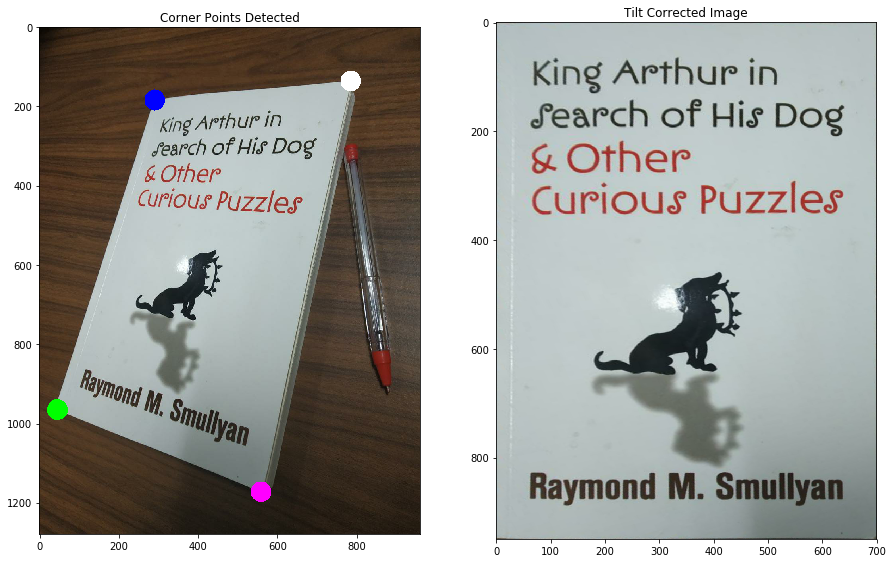

In [21]:
img = input_image.copy()

fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(corner_detector.visualize_corner_points(img, points, 26))
plt.title("Corner Points Detected")


ax = fig.add_subplot(1, 2,2)
plt.imshow(cv2.resize(final_output, (700, 950)))
plt.title("Tilt Corrected Image")
plt.show()

<h2> Visualization of All Stages </h2>

In [22]:
def show_all(stage, row_size, column_size):
    """This function takes all six stage images along with input image packed in a tupel
    and display them with proper labeling"""

    fig = plt.figure(figsize = (row_size, column_size))

    ax = fig.add_subplot(2, 3, 1)
    plt.imshow(stage[0])
    plt.title("INPUT Image")
    plt.axis('Off')

    ax = fig.add_subplot(2, 3,2)
    plt.imshow(stage[1], cmap = 'gray')
    plt.title("STAGE 1 : Gray Scaled Image")
    plt.axis('Off')


    ax = fig.add_subplot(2, 3, 3)
    plt.imshow(stage[2], cmap = 'gray')
    plt.title("STAGE 2 :Gaussian Blurred Image")
    plt.axis('Off')


    ax = fig.add_subplot(2, 3,4)
    plt.imshow(stage[3], cmap = 'gray')
    plt.title("STAGE 3 : Edge Detection : Canny Operator")
    plt.axis('Off')


    ax = fig.add_subplot(2, 3, 5)
    plt.imshow(stage[4], cmap = 'gray')
    plt.title("STAGE 4 : Line Detection : Hough Transform")
    plt.axis('Off')


    ax = fig.add_subplot(2, 3, 6)
    plt.imshow(stage[5])
    plt.title("STAGE 5 : Corner Points Detection")
    plt.axis('Off')

    plt.show()


    plt.figure(figsize=(7,7))
    # ax = fig.add_subplot(4, 2, 7)
    plt.imshow(stage[6])
    plt.title("STAGE 6 : Perspective Transform : OUTPUT")
    plt.axis('off')
    plt.savefig('./data/out.png', bbox_inches = 'tight')    
    

    plt.show()

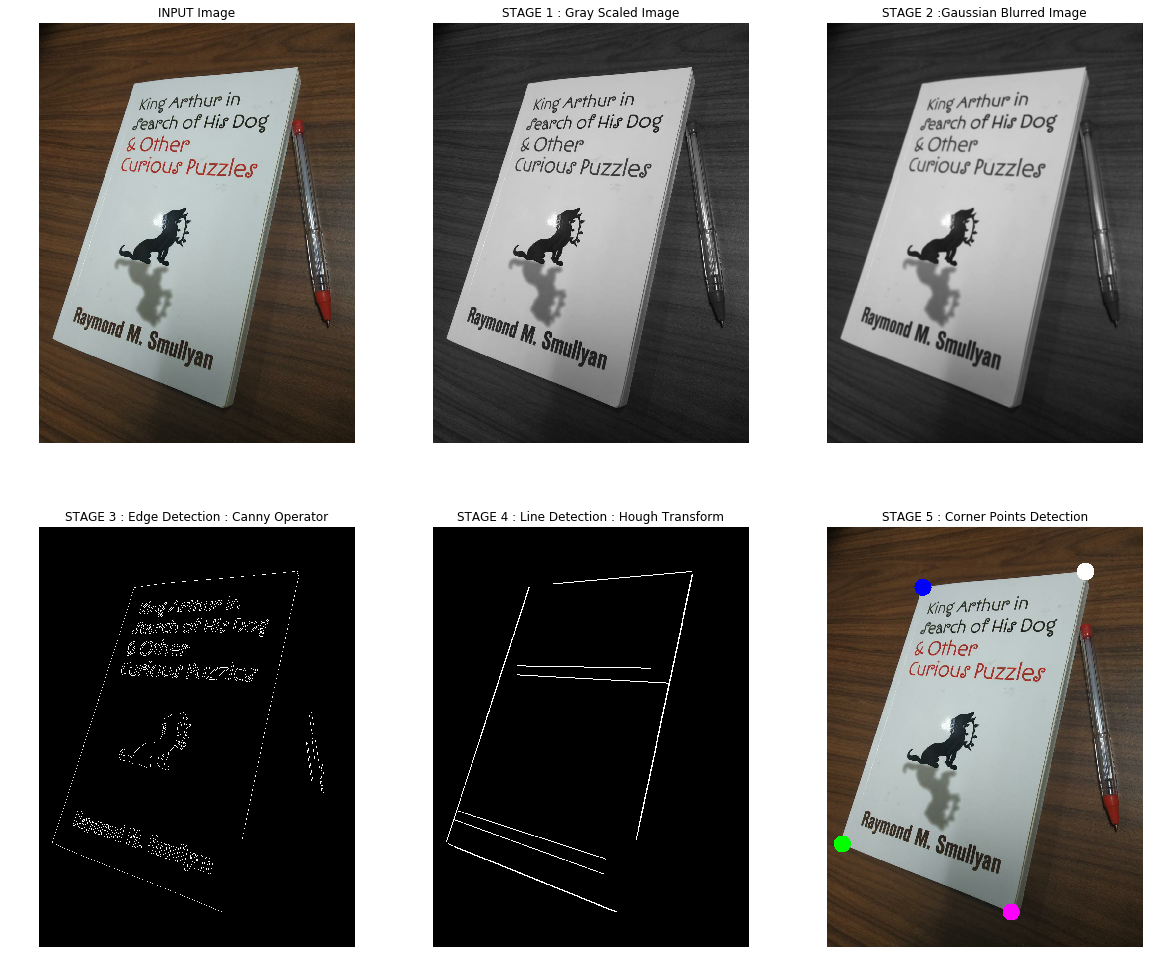

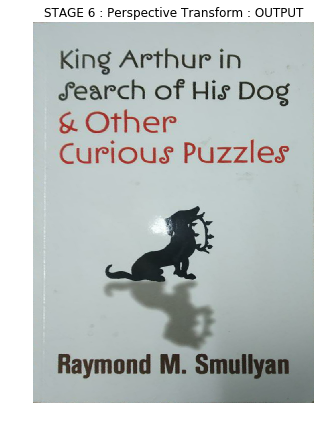

In [23]:
# packing all stage images in a tuple.
prime_demo = (input_image, gray, filtered_image,
              edges, hough_lines, plot_corner_points, cv2.resize(final_output, (700, 950)))


show_all(prime_demo, 20, 17)     # displaying them all

<h1> Experiments: </h1>

In [24]:
# this modeule takes tilted input image and returns all the stages of tilt correction.
from tilt_correction import stage_wise_tilt_correction

<h2> Test Case 1 </h2>

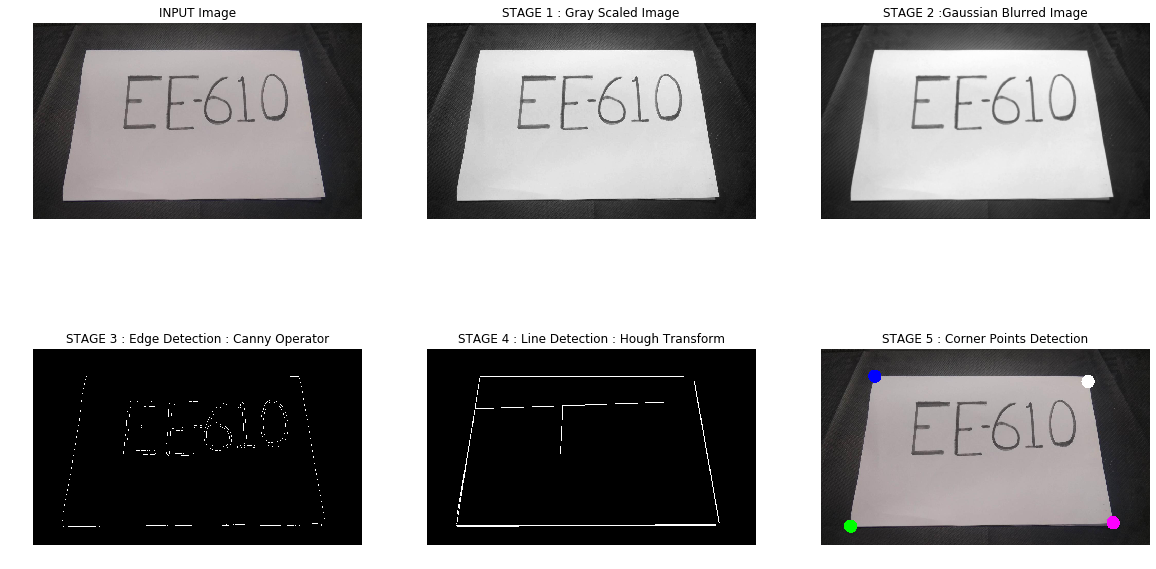

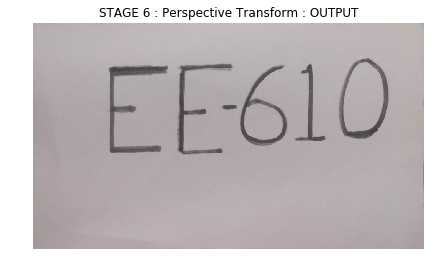

In [25]:
test_image1 = np.array(Image.open('./data/test_case1.jpeg')) # reading the input image
result1 = stage_wise_tilt_correction(test_image1)
show_all(result1, 20, 11)

<h2> Test Case 2 </h2>

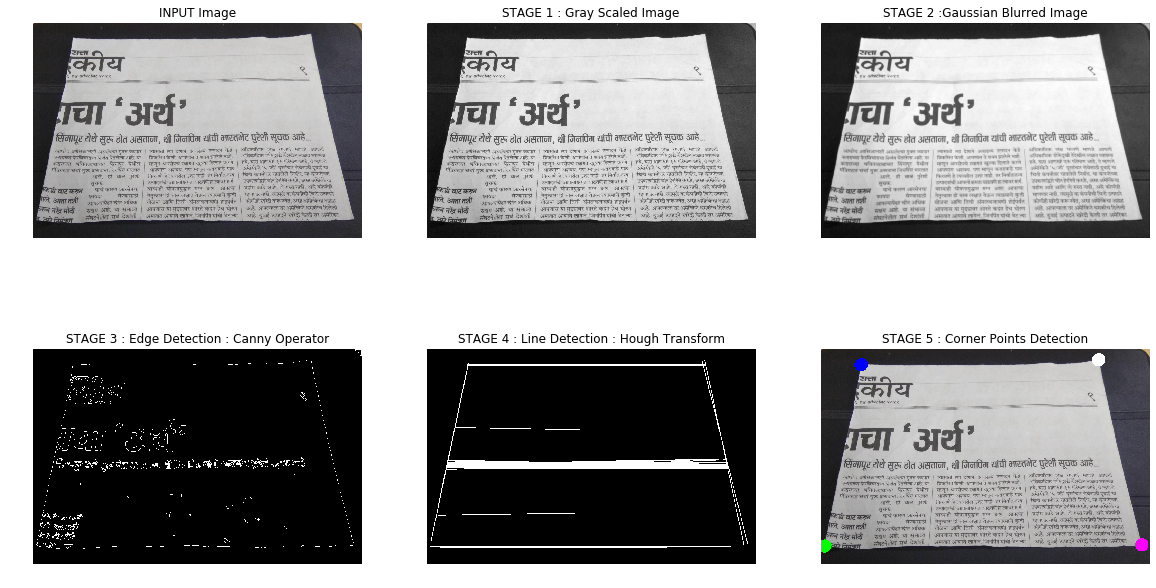

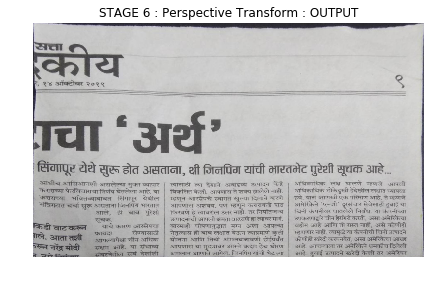

In [26]:
test_image2 = np.array(Image.open('./data/test_case2.jpeg')) # reading the input image
result2 = stage_wise_tilt_correction(test_image2)
show_all(result2, 20, 11)

<h2> Test Case 3 </h2>

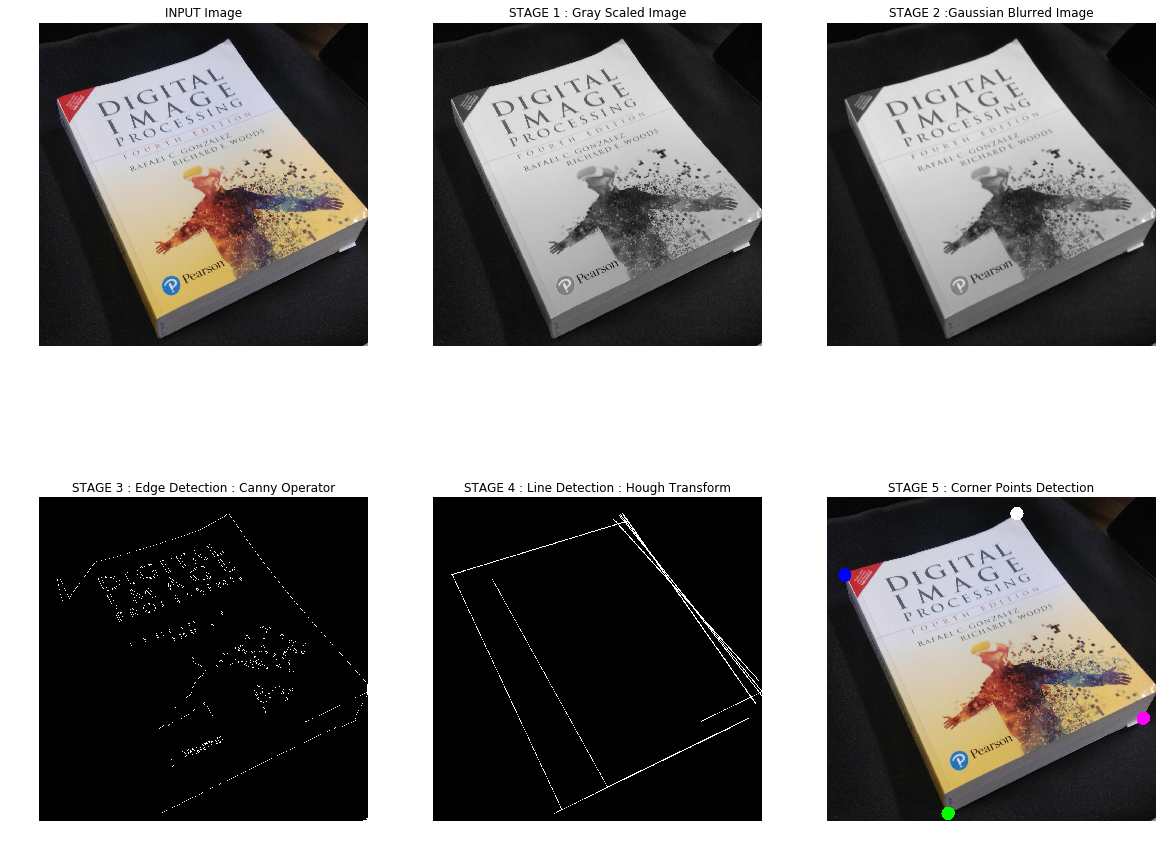

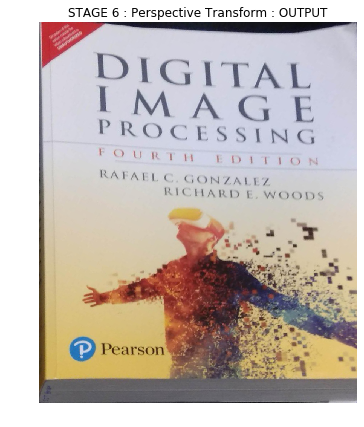

In [27]:
test_image3 = np.array(Image.open('./data/test_case3.jpeg')) # reading the input image
result3 = stage_wise_tilt_correction(test_image3)
show_all(result3, 20, 16)

<h2> Test Case 4 </h2>

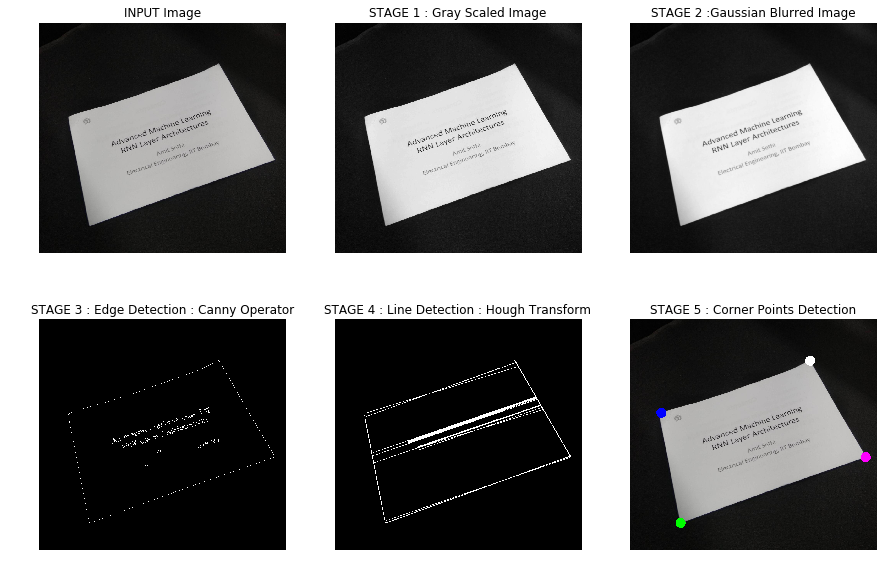

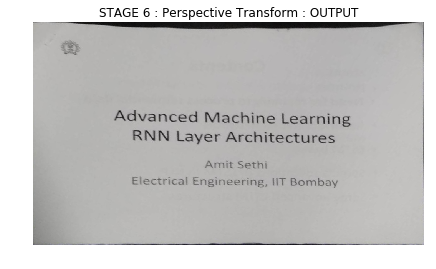

In [28]:
test_image4 = np.array(Image.open('./data/test_case4.jpeg')) # reading the input image
result4 = stage_wise_tilt_correction(test_image4)
show_all(result4, 15, 10)

<h2> Test Case 5 </h2>

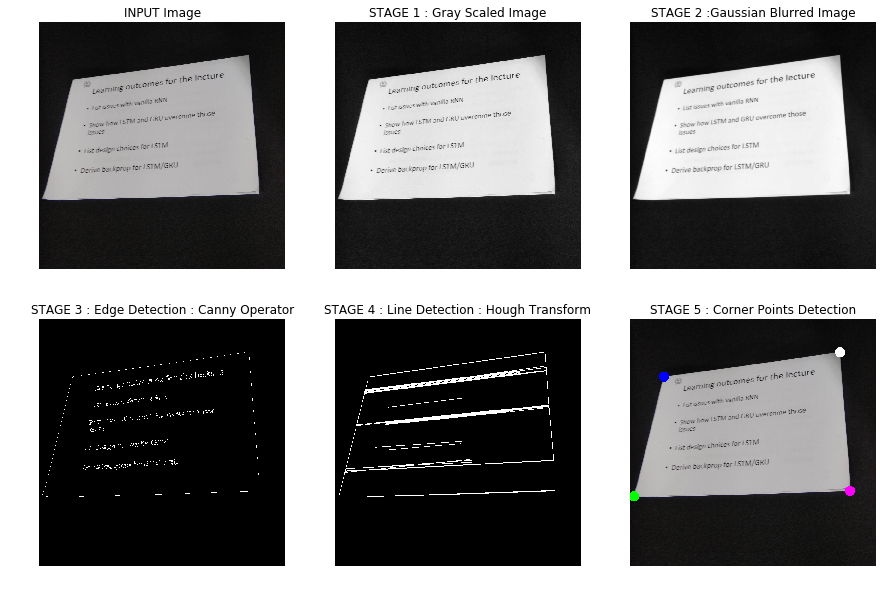

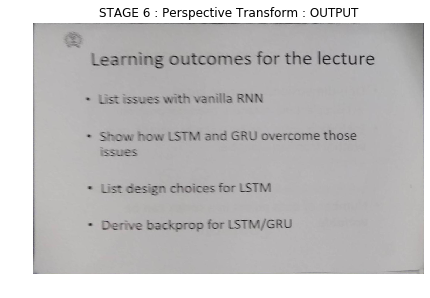

In [29]:
test_image5 = np.array(Image.open('./data/test_case5.jpeg')) # reading the input image
result5 = stage_wise_tilt_correction(test_image5)
show_all(result5, 15, 10)

<h2> Test Case 6 </h2>

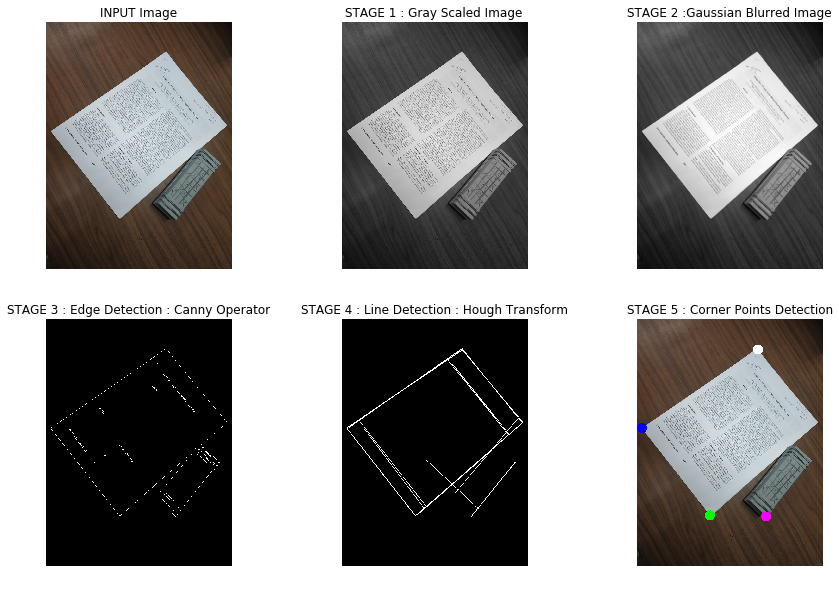

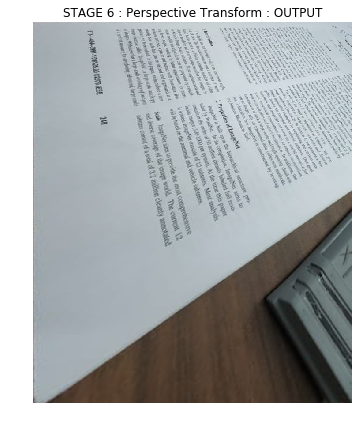

In [30]:
test_image6 = np.array(Image.open('./data/test_case6.jpeg')) # reading the input image
result6 = stage_wise_tilt_correction(test_image6)
show_all(result6, 15, 10)

<b> Saving the figures for report </b>

In [31]:
# fig = plt.figure(figsize = (12, 15))

# ax = fig.add_subplot(2, 2, 1)
# plt.imshow(result6[0])
# plt.title('INPUT Image')
# plt.axis('off')

# ax = fig.add_subplot(2, 2,2)
# plt.imshow(result6[3], cmap = 'gray')
# plt.axis('off')

# ax = fig.add_subplot(2, 2,3)
# plt.imshow(result6[5])
# plt.axis('off')

# ax = fig.add_subplot(2, 2,4)
# plt.imshow(result6[6])
# plt.title('OUPUT Image')
# plt.axis('off')


# plt.savefig('./data/report_fig/case6.png', bbox_inches = 'tight')
